## Comparing bits in Morgan fingerprints

For more information, see:

[Getting Started with the RDKit in Python](https://www.rdkit.org/docs/GettingStartedInPython.html)

[Extended-Connectivity Fingerprints](https://pubs.acs.org/doi/pdf/10.1021/ci100050t)

In [1]:
import numpy as np
import pandas as pd
from rdkit import Chem
from rdkit.Chem import AllChem
from rdkit.Chem import Draw
from rdkit.Chem.Draw import IPythonConsole

Let's generate fingerprints for these three structures:

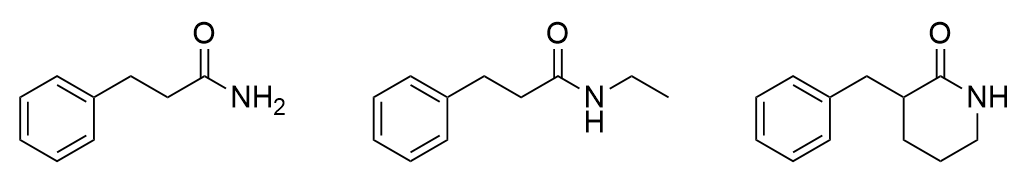

In [2]:
smi = ["NC(CCC1=CC=CC=C1)=O", "O=C(NCC)CCC1=CC=CC=C1", "O=C(NCCC1)C1CC2=CC=CC=C2"]
mol = [Chem.MolFromSmiles(m) for m in smi]
fps = [np.array(Chem.rdMolDescriptors.GetMorganFingerprintAsBitVect(m, 2, 1024)) for m in mol]

df = pd.DataFrame(fps, columns=[str(i) for i in range(1024)])
df

,0,1,2,3,4,5,6,7,8,9,...,1014,1015,1016,1017,1018,1019,1020,1021,1022,1023
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,1,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0


Let's see which are the active bits in each fingerprint. Note that a lot of them are similar between fingerprints

In [3]:
non_zero_0 = df.loc[0].to_numpy().nonzero()
non_zero_0

(array([ 21,  42,  64,  66,  80, 140, 147, 175, 219, 356, 389, 540, 545,
        638, 650, 726, 730, 807, 849, 874, 893], dtype=int64),)

In [4]:
non_zero_1 = df.loc[1].to_numpy().nonzero()
non_zero_1

(array([ 21,  33,  41,  42,  64,  66,  80, 128, 175, 197, 219, 294, 356,
        389, 540, 565, 600, 650, 681, 697, 702, 726, 730, 807, 849, 893],
       dtype=int64),)

In [5]:
non_zero_2 = df.loc[2].to_numpy().nonzero()
non_zero_2

(array([   4,   10,   42,   64,   80,   88,   90,  175,  278,  301,  305,
         314,  327,  356,  389,  403,  432,  458,  587,  650,  726,  730,
         742,  842,  848,  849,  881,  926, 1019], dtype=int64),)

More active bits are the same for structures 0 and 1 than for 0 and 2.

In [6]:
union_0_1 = np.intersect1d(non_zero_0, non_zero_1)
union_0_1

array([ 21,  42,  64,  66,  80, 175, 219, 356, 389, 540, 650, 726, 730,
       807, 849, 893], dtype=int64)

In [7]:
union_0_2 = np.intersect1d(non_zero_0, non_zero_2)
union_0_2

array([ 42,  64,  80, 175, 356, 389, 650, 726, 730, 849], dtype=int64)

In [8]:
# Bits that are active in all three molecules
union = np.intersect1d(non_zero_2, np.intersect1d(non_zero_0, non_zero_1))
union

array([ 42,  64,  80, 175, 356, 389, 650, 726, 730, 849], dtype=int64)

Let's generate the fingerprints again, but this time, we use the `bitInfo` parameter to save information on the atoms involved in setting a bit, which will allow us to draw the substructure. To draw a substructure corresponding to an active bit, replace the second argument in `Draw.DrawMorganBit()` by the value you want.

In [9]:
bi1 = {}
fp = AllChem.GetMorganFingerprintAsBitVect(mol[1], 2, 1024, bitInfo=bi1)

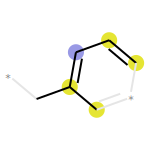

In [10]:
# Bit 42 is active in all molecules, and corresponds to a substructure of the aromatic ring
Draw.DrawMorganBit(mol[1], 42, bi1, useSVG=True)

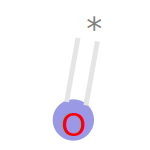

In [11]:
# Bit 650 is active in all molecules, and corresponds to the carbonyl oxygen
Draw.DrawMorganBit(mol[1], 650, bi1, useSVG=True)

You can check for other values in `union`, and see that these are indeed common substructures for all three molecules.

Now, let's see which bits are active in one fingerprint, but not in another.

In [12]:
# Bits active in 2 but not in 0
diff = np.setdiff1d(non_zero_2, non_zero_0)
diff

array([   4,   10,   88,   90,  278,  301,  305,  314,  327,  403,  432,
        458,  587,  742,  842,  848,  881,  926, 1019], dtype=int64)

In [13]:
bi2 = {}
fp2 = AllChem.GetMorganFingerprintAsBitVect(mol[2], 2, 1024, bitInfo=bi2)

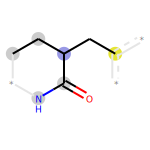

In [14]:
# This substructure has a tertiary carbon atom and is unique to 2
Draw.DrawMorganBit(mol[2], 881, bi2, useSVG=True)

Note, however, that the substructure below, which corresponds to a nitrogen atom bonded to two carbon atoms, should also be present in 1, however, the bits they activate are different (it's bit 90 for 2 and 128 for 1). I believe this is because the carbon atom is cyclic in 2, and is considered of a different type.

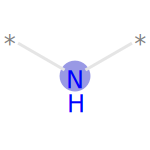

In [15]:
Draw.DrawMorganBit(mol[2], 90, bi2, useSVG=True)

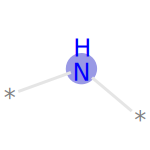

In [16]:
# Bit 128 is active in 1, but not in 2, even though they both correspond to nitrogen bonded to two carbon atoms
Draw.DrawMorganBit(mol[1], 128, bi1, useSVG=True)